# Agent Chat with Multimodal Models

We use **LLaVA** as an example for the multimodal feature.  More information about LLaVA can be found in their [GitHub page](https://github.com/haotian-liu/LLaVA)


This notebook contains the following information and examples:

1. Install [LLaVA package](#install)
2. Setup LLaVA Model
    - Option 1: Use [API calls from `Replicate`](#replicate)
    - Option 2: Setup [LLaVA locally (requires GPU)](#local)
2. Application 1: [Image Chat](#app-1)
3. Application 2: [Figure Creator](#app-2)

In [37]:
# We use this variable to control where you want to host LLaVA, locally or remotely?
# More details in the two setup options below.
LLAVA_MODE = "remote" # Either "local" or "remote"
assert LLAVA_MODE in ["local", "remote"]

In [2]:
# we will override the following variables later.
MODEL_NAME = "" 
SEP = "###"

<a id="install"></a>
## Install the LLaVA library

Please follow the LLaVA GitHub [page](https://github.com/haotian-liu/LLaVA/) to install LLaVA.


#### Download the package
```bash
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA
```

#### Install the inference package
```bash
conda create -n llava python=3.10 -y
conda activate llava
pip install --upgrade pip  # enable PEP 660 support
pip install -e .
```

### Don't forget AutoGen in the new environment
```bash
pip install pyautogen
```

In [3]:
import requests
import json
import os
from llava.conversation import default_conversation as conv
from llava.conversation import Conversation

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent
from termcolor import colored
import random

[2023-10-20 12:47:04,159] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


<a id="replicate"></a>
## (Option 1, preferred) Use API Calls from Replicate [Remote]
We can also use [Replicate](https://replicate.com/yorickvp/llava-13b/api) to use LLaVA directly, which will host the model for you.

1. Run `pip install replicate` to install the package
2. You need to get an API key from Replicate from your [account setting page](https://replicate.com/account/api-tokens)
3. Next, copy your API token and authenticate by setting it as an environment variable:
    `export REPLICATE_API_TOKEN=<paste-your-token-here>` 
4. You need to enter your credit card information for Replicate 🥲
    

In [4]:
# pip install replicate
# import os
## alternatively, you can put your API key here for the environment variable.
# os.environ["REPLICATE_API_TOKEN"] = "r8_xyz your api key goes here~"

In [5]:
if LLAVA_MODE == "remote":
    import replicate

<a id="local"></a>
## [Option 2] Setup LLaVA Locally


Some helpful packages and dependencies:
```bash
conda install -c nvidia cuda-toolkit
```


### Launch

In one terminal, start the controller first:
```bash
python -m llava.serve.controller --host 0.0.0.0 --port 10000
```


Then, in another terminal, start the worker, which will load the model to the GPU:
```bash
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-13b
``

**Note: make sure the environment of this notebook also installed the llava package from `pip install -e .`**

In [32]:
# Run this code block only if you want to run LlaVA locally
if LLAVA_MODE == "local":
    # Setup some global constants for convenience
    # Note: make sure the addresses below are consistent with your setup in LLaVA 
    CONTROLLER_ADDR = "http://0.0.0.0:10000"
    SEP =  conv.sep
    ret = requests.post(CONTROLLER_ADDR + "/list_models")
    print(ret.json())
    MODEL_NAME = ret.json()["models"][0]
    print("Model Name:", MODEL_NAME)

{'models': ['llava-v1.5-13b']}
Model Name: llava-v1.5-13b


# Multimodal Functions

The Multimodal Functions library provides a set of utilities to manage and process multimodal data, focusing on textual and image components. The library allows you to format prompts, extract image paths, and handle image data in various formats.

## Functions


### `get_image_data`

This function retrieves the content of an image specified by a file path or URL and optionally converts it to base64 format. It can handle both web-hosted images and locally stored files.


### `lmm_formater`

This function formats a user-provided prompt containing `<img ...>` tags, replacing these tags with `<image>` or numbered versions like `<image 1>`, `<image 2>`, etc., and extracts the image locations. It returns a tuple containing the new formatted prompt and a list of image data.

In [7]:
import base64
import re
from io import BytesIO

from PIL import Image

import re


def get_image_data(image_file, use_b64=True):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        content = response.content
    elif re.match(r"data:image/(?:png|jpeg);base64,", image_file):
        return re.sub(r"data:image/(?:png|jpeg);base64,", "", image_file)
    else:
        image = Image.open(image_file).convert('RGB')
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        content = buffered.getvalue()
        
    if use_b64:
        return base64.b64encode(content).decode('utf-8')
    else:
        return content

def lmm_formater(prompt: str, order_image_tokens: bool = False) -> Tuple[str, List[str]]:
    """
    Formats the input prompt by replacing image tags and returns the new prompt along with image locations.
    
    Parameters:
        - prompt (str): The input string that may contain image tags like <img ...>.
        - order_image_tokens (bool, optional): Whether to order the image tokens with numbers. 
            It will be useful for GPT-4V. Defaults to False.
    
    Returns:
        - Tuple[str, List[str]]: A tuple containing the formatted string and a list of images (loaded in b64 format).
    """
    
    # Initialize variables
    new_prompt = prompt
    image_locations = []
    images = []
    image_count = 0
    
    # Regular expression pattern for matching <img ...> tags
    img_tag_pattern = re.compile(r'<img ([^>]+)>')
    
    # Find all image tags
    for match in img_tag_pattern.finditer(prompt):
        image_location = match.group(1)
        
        try: 
            img_data = get_image_data(image_location)
        except:
            # Remove the token
            print(f"Warning! Unable to load image from {image_location}")
            new_prompt = new_prompt.replace(match.group(0), "", 1)
            continue
        
        image_locations.append(image_location)
        images.append(img_data)
        
        # Increment the image count and replace the tag in the prompt
        new_token = f'<image {image_count}>' if  order_image_tokens else "<image>"

        new_prompt = new_prompt.replace(match.group(0), new_token, 1)
        image_count += 1
        
    return new_prompt, images



def gpt4v_formatter(prompt: str) -> List[Union[str, dict]]:
    """
    Formats the input prompt by replacing image tags and returns a list of text and images.
    
    Parameters:
        - prompt (str): The input string that may contain image tags like <img ...>.

    Returns:
        - List[Union[str, dict]]: A list of alternating text and image dictionary items.
    """
    output = []
    last_index = 0
    image_count = 0
    
    # Regular expression pattern for matching <img ...> tags
    img_tag_pattern = re.compile(r'<img ([^>]+)>')
    
    # Find all image tags
    for match in img_tag_pattern.finditer(prompt):
        image_location = match.group(1)
        
        try:
            img_data = get_image_data(image_location)
        except:
            # Warning and skip this token
            print(f"Warning! Unable to load image from {image_location}")
            continue

        # Add text before this image tag to output list
        output.append(prompt[last_index:match.start()])
        
        # Add image data to output list
        output.append({"image": img_data})
        
        last_index = match.end()
        image_count += 1

    # Add remaining text to output list
    output.append(prompt[last_index:])
    
    return output


def extract_img_paths(paragraph: str) -> list:
    """
    Extract image paths (URLs or local paths) from a text paragraph.
    
    Parameters:
        paragraph (str): The input text paragraph.
        
    Returns:
        list: A list of extracted image paths.
    """
    # Regular expression to match image URLs and file paths
    img_path_pattern = re.compile(r'\b(?:http[s]?://\S+\.(?:jpg|jpeg|png|gif|bmp)|\S+\.(?:jpg|jpeg|png|gif|bmp))\b', 
                                  re.IGNORECASE)
    
    # Find all matches in the paragraph
    img_paths = re.findall(img_path_pattern, paragraph)
    return img_paths


def _to_pil(data):
    return Image.open(BytesIO(base64.b64decode(data)))



def llava_call_binary(prompt: str, images: list, 
                      model_name:str = MODEL_NAME, 
                      max_new_tokens:int=1000, temperature: float=0.5, seed: int = 1):
    # TODO 1: add caching around the LLaVA call to save compute and cost
    # TODO 2: add `seed` to ensure reproducibility. The seed is not working now.
    if LLAVA_MODE == "local":
        headers = {"User-Agent": "LLaVA Client"}
        pload = {
            "model": model_name,
            "prompt": prompt,
            "max_new_tokens": max_new_tokens,
            "temperature": temperature,
            "stop": SEP,
            "images": images,
        }

        response = requests.post(CONTROLLER_ADDR + "/worker_generate_stream", headers=headers,
                json=pload, stream=False)

        for chunk in response.iter_lines(chunk_size=8192, decode_unicode=False, delimiter=b"\0"):
            if chunk:
                data = json.loads(chunk.decode("utf-8"))
                output = data["text"].split(SEP)[-1]
    elif LLAVA_MODE == "remote":
        # The Replicate version of the model only support 1 image for now.
        img = 'data:image/jpeg;base64,' + images[0]
        response = replicate.run(
            "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
            input={"image": img, "prompt": prompt.replace("<image>", " "), "seed": seed}
        )
        # The yorickvp/llava-13b model can stream output as it's running.
        # The predict method returns an iterator, and you can iterate over that output.
        output = ""
        for item in response:
            # https://replicate.com/yorickvp/llava-13b/versions/2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591/api#output-schema
            output += item
        
    # Remove the prompt and the space.
    output = output.replace(prompt, "").strip().rstrip()
    return output
    

def llava_call(prompt:str, model_name: str=MODEL_NAME, images: list=[], 
               max_new_tokens:int=1000, temperature: float=0.5, seed: int = 1) -> str:
    """
    Makes a call to the LLaVA service to generate text based on a given prompt and optionally provided images.

    Args:
        - prompt (str): The input text for the model. Any image paths or placeholders in the text should be replaced with "<image>".
        - model_name (str, optional): The name of the model to use for the text generation. Defaults to the global constant MODEL_NAME.
        - images (list, optional): A list of image paths or URLs. If not provided, they will be extracted from the prompt.
            If provided, they will be appended to the prompt with the "<image>" placeholder.
        - max_new_tokens (int, optional): Maximum number of new tokens to generate. Defaults to 1000.
        - temperature (float, optional): temperature for the model. Defaults to 0.5.

    Returns:
        - str: Generated text from the model.

    Raises:
        - AssertionError: If the number of "<image>" tokens in the prompt and the number of provided images do not match.
        - RunTimeError: If any of the provided images is empty.

    Notes:
    - The function uses global constants: CONTROLLER_ADDR and SEP.
    - Any image paths or URLs in the prompt are automatically replaced with the "<image>" token.
    - If more images are provided than there are "<image>" tokens in the prompt, the extra tokens are appended to the end of the prompt.
    """

    if len(images) == 0:
        prompt, images = lmm_formater(prompt, order_image_tokens=False)
    else:
        # Append the <image> token if missing
        assert prompt.count("<image>") <= len(images), "the number "
        "of image token in prompt and in the images list should be the same!"
        num_token_missing = len(images) - prompt.count("<image>")
        prompt += " <image> " * num_token_missing
        images = [get_image_data(x) for x in images]
    
    for im in images:
        if len(im) == 0:
            raise RunTimeError("An image is empty!")

    return llava_call_binary(prompt, images, 
                      model_name, 
                      max_new_tokens, temperature, seed)


Here is the image that we are going to use.

![Image](https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png)

We can call llava by providing the prompt and images separately.


In [19]:
out = llava_call("Describe this image: <image>", 
                 images=["https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png"])
print(out)

The image features a small, orange, and black toy animal, possibly a stuffed dog or a toy horse, with flames coming out of its back. The toy is sitting on a table, and it appears to be a unique and creative design. The toy is wearing glasses, adding a touch of whimsy to its appearance. The overall scene is quite eye-catching and playful.


Or, we can also call LLaVA with only prompt, with images embedded in the prompt with the <img xxx> format


In [9]:
out = llava_call("Describe this image in one sentence: <img https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png>")
print(out)

A red toy with flames and glasses on it.


<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

In [10]:

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

llm_config = {"config_list": config_list_gpt4, "seed": 42}

DEFAULT_LMM_SYS_MSG = """You are a helpful AI assistant.
You can also view images, where the "<image i>" represent the i-th image you received."""

class MultimodalConversableAgent(ConversableAgent):
    def __init__(
        self,
        name: str,
        system_message: Optional[Tuple[str, List]] = DEFAULT_LMM_SYS_MSG,
        is_termination_msg=None,
        *args,
        **kwargs,
    ):
        """
        Args:
            name (str): agent name.
            system_message (str): system message for the ChatCompletion inference.
                Please override this attribute if you want to reprogram the agent.
            **kwargs (dict): Please refer to other kwargs in
                [ConversableAgent](conversable_agent#__init__).
        """
        super().__init__(
            name,
            system_message,
            is_termination_msg=is_termination_msg,
            *args,
            **kwargs,
        )
        
        self.update_system_message(system_message)
        self._is_termination_msg = (
            is_termination_msg if is_termination_msg is not None else (lambda x: x.get("content")[-1] == "TERMINATE")
        )
            
    @property
    def system_message(self) -> List:
        """Return the system message."""
        return self._oai_system_message[0]["content"]

    def update_system_message(self, system_message: str):
        """Update the system message.

        Args:
            system_message (str): system message for the ChatCompletion inference.
        """
        self._oai_system_message[0]["content"] = self._message_to_dict(system_message)["content"]
        self._oai_system_message[0]["role"] = "system"
        
    @staticmethod
    def _message_to_dict(message: Union[Dict, List, str]):
        """Convert a message to a dictionary.

        The message can be a string or a dictionary. The string will be put in the "content" field of the new dictionary.
        """
        if isinstance(message, str):
            return {"content": gpt4v_formatter(message)}
        if isinstance(message, list):
            return {"content": message}
        else:
            return message
        
    def _content_str(self, content: List) -> str:
        rst = ""
        for item in content:
            if isinstance(item, str):
                rst += item
            else:
                assert isinstance(item, dict) and "image" in item, ("Wrong content format.")
                rst += "<image>"
        return rst
                
    def _print_received_message(self, message: Union[Dict, str], sender: Agent):
        # print the message received
        print(colored(sender.name, "yellow"), "(to", f"{self.name}):\n", flush=True)
        if message.get("role") == "function":
            func_print = f"***** Response from calling function \"{message['name']}\" *****"
            print(colored(func_print, "green"), flush=True)
            print(self._content_str(message["content"]), flush=True)
            print(colored("*" * len(func_print), "green"), flush=True)
        else:
            content = message.get("content")
            if content is not None:
                if "context" in message:
                    content = oai.ChatCompletion.instantiate(
                        content,
                        message["context"],
                        self.llm_config and self.llm_config.get("allow_format_str_template", False),
                    )
                print(self._content_str(content), flush=True)
            if "function_call" in message:
                func_print = f"***** Suggested function Call: {message['function_call'].get('name', '(No function name found)')} *****"
                print(colored(func_print, "green"), flush=True)
                print(
                    "Arguments: \n",
                    message["function_call"].get("arguments", "(No arguments found)"),
                    flush=True,
                    sep="",
                )
                print(colored("*" * len(func_print), "green"), flush=True)
        print("\n", "-" * 80, flush=True, sep="")
    # TODO: we may want to udpate `generate_code_execution_reply` or `extract_code` for the "content" type change.
    

DEFAULT_LLAVA_SYS_MSG = "You are an AI agent and you can view images."
class LLaVAAgent(MultimodalConversableAgent):
    def __init__(
        self,
        name: str,
        system_message: Optional[Tuple[str, List]] = DEFAULT_LLAVA_SYS_MSG,
        *args,
        **kwargs,
    ):
        """
        Args:
            name (str): agent name.
            system_message (str): system message for the ChatCompletion inference.
                Please override this attribute if you want to reprogram the agent.
            **kwargs (dict): Please refer to other kwargs in
                [ConversableAgent](conversable_agent#__init__).
        """
        super().__init__(
            name,
            system_message=system_message,
            *args,
            **kwargs,
        )
        self.register_reply([Agent, None], reply_func=LLaVAAgent._image_reply, position=0)

    def _image_reply(
        self,
        messages=None,
        sender=None, config=None
    ):
        # Note: we did not use "llm_config" yet.
        # TODO 1: make the LLaVA API design compatible with llm_config
        
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        # The formats for LLaVA and GPT are different. So, we manually handle them here.
        # TODO: format the images from the history accordingly.
        images = []
        prompt = self._content_str(self.system_message) + "\n"
        for msg in messages:
            role = "Human" if msg["role"] == "user" else "Assistant"
            images += [d["image"] for d in msg["content"] if isinstance(d, dict)]
            content_prompt = self._content_str(msg["content"])
            prompt += f"{SEP}{role}: {content_prompt}\n"
        prompt += "\n" + SEP + "Assistant: "
        print(colored(prompt, "blue"))
    
        out = ""
        retry = 10
        while len(out) == 0 and retry > 0:
            # image names will be inferred automatically from llava_call
            out = llava_call_binary(prompt=prompt, images=images, temperature=0, max_new_tokens=2000)
            retry -= 1
            
        assert out != "", "Empty response from LLaVA."
        
        
        return True, out

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LLaVA in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [47]:
image_agent = LLaVAAgent(
    name="image-explainer",
    max_consecutive_auto_reply=0
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat"
    },
    human_input_mode="NEVER", # Try between ALWAYS or NEVER
#     llm_config=llm_config,
    max_consecutive_auto_reply=0,
)

# Ask the question with an image
user_proxy.initiate_chat(image_agent, 
                         message="""What's the breed of this dog? 
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

User_proxy (to image-explainer):

What's the breed of this dog? 
<image>.

--------------------------------------------------------------------------------
You are an AI agent and you can view images.
###Human: What's the breed of this dog? 
<image>.

###Assistant: 
image-explainer (to User_proxy):

The dog in the image is a poodle.

--------------------------------------------------------------------------------


Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [49]:
# Ask the question with an image
user_proxy.send(message="""How about these breeds? 
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""", 
                recipient=image_agent)

User_proxy (to image-explainer):

How about these breeds? 
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------
You are an AI agent and you can view images.
###Human: What's the breed of this dog? 
<image>.
###Assistant: The dog in the image is a poodle.
###Human: How about these breeds? <image> and <image>
Among all the breeds, which one barks less?
###Assistant: The breeds of the dog in the image are a poodle and a terrier. Among the two, the poodle is known to bark less.
###Human: How about these breeds? 
<image>

Among the breeds, which one barks less?

###Assistant: 
image-explainer (to User_proxy):

Among the breeds, the poodle is known to bark less.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LLaVA-based agent that provides comments and feedback on the generated image.

In [13]:
class FigureCreator(AssistantAgent):

    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.
        
        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.
        
        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message=
            "Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith(
                "TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False
            },
            llm_config=self.llm_config,
        )

        critics = LLaVAAgent(
            name="Critics",
            system_message=
            "Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. If you think the figures is good enough, then simply say NO_ISSUES",
            llm_config=self.llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=0,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.show()
        
        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>",
                           recipient=critics,
                           request_reply=True)
            
            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True)
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            
        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

To plot the figure using the data from the provided URL, we'll first download the data, then use the pandas library to read the CSV data and finally, use the matplotlib library to plot the temperature high and low.

Step 1: Download the CSV file
Step 2: Read the CSV file using pandas
Step 3: Plot the temperature high and low using matplotlib

Please execute the following code:

```python
import pandas as pd
import matplotlib.p

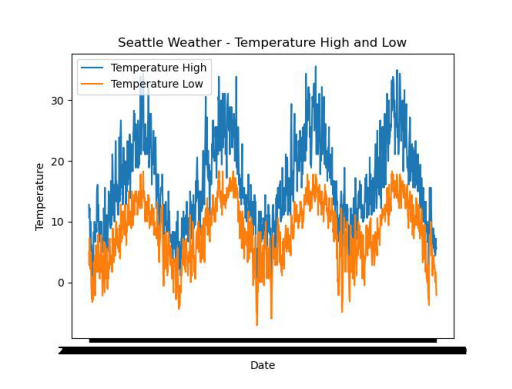

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. If you think the figures is good enough, then simply say NO_ISSUES
###Human: Improve <image>

###Assistant: 
Critics (to Commander):

The input figure shows a graph with three different colored lines, representing temperature high, temperature low, and temperature average. The graph is labeled "Seattle Weather - Temperature High and Low." However, the graph is not well-organized, and the lines are not clearly distinguishable.

To improve the figure, one could use a more visually appealing color scheme for the lines, such as different shades of blue, green, and orange. Additionally, the labels for the temperature high, temperature low, and temperature average could be placed above or below the respective lines to make them more easily readable. The graph c

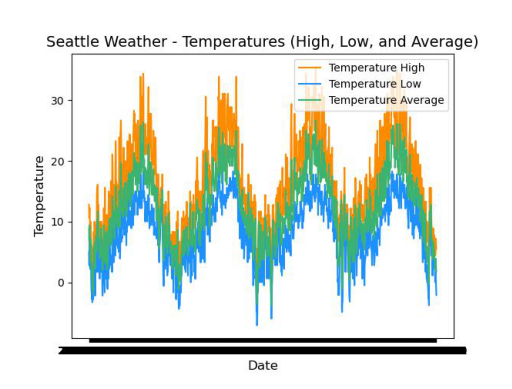

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. If you think the figures is good enough, then simply say NO_ISSUES
###Human: Improve <image>
###Assistant: The input figure shows a graph with three different colored lines, representing temperature high, temperature low, and temperature average. The graph is labeled "Seattle Weather - Temperature High and Low." However, the graph is not well-organized, and the lines are not clearly distinguishable.

To improve the figure, one could use a more visually appealing color scheme for the lines, such as different shades of blue, green, and orange. Additionally, the labels for the temperature high, temperature low, and temperature average could be placed above or below the respective lines to make them more easily readable. The graph could also benefit from a cl

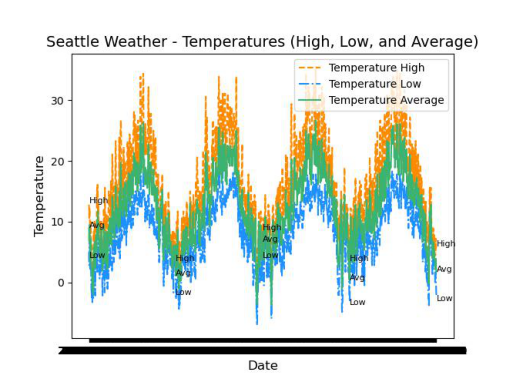

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [14]:
import matplotlib.pyplot as plt
import time

creator = FigureCreator(
    name="Figure Creator~",
    llm_config=llm_config
    
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    llm_config=llm_config,
    max_consecutive_auto_reply=0
)

user_proxy.initiate_chat(creator, message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""")
